<a href="https://colab.research.google.com/github/Siuuuuuu0/ML-DL/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data initialization

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

torch.__version__

'2.9.0+cpu'

In [28]:
w = 2.7
b = -6

def gen_data(w=2.7, b=-6, start=-5, end=5, n_samples=100):

  X = torch.linspace(start, end, n_samples).unsqueeze(dim=1)

  noise = torch.randn(n_samples, 1)*0.5
  #N(0, 0.5^2)=N(0, 25)

  y = w * X + b + noise

  return X, y

X, y = gen_data()

overall_results = {}

X[:5], y[:5]

(tensor([[-5.0000],
         [-4.8990],
         [-4.7980],
         [-4.6970],
         [-4.5960]]),
 tensor([[-19.7208],
         [-19.3112],
         [-18.3771],
         [-19.0110],
         [-18.1090]]))

In [3]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_test)

#sklearn train test split in pytorch sgd

(80, 20)

In [4]:
def plot_predictions(
    train_data = X_train,
    train_labels = y_train,
    test_data = X_test,
    test_labels = y_test,
    predictions = None
):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="r", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="g", s=4, label="Predictions")

  plt.legend(prop={"size":14})



In [5]:
def plot_loss_values(epoch_count, loss_values, test_loss_values=None):
  plt.figure(figsize=(10, 7))
  plt.plot(epoch_count, loss_values, label="Train loss")
  plt.plot(epoch_count, test_loss_values, label="Test loss")
  plt.title("Training and test loss curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

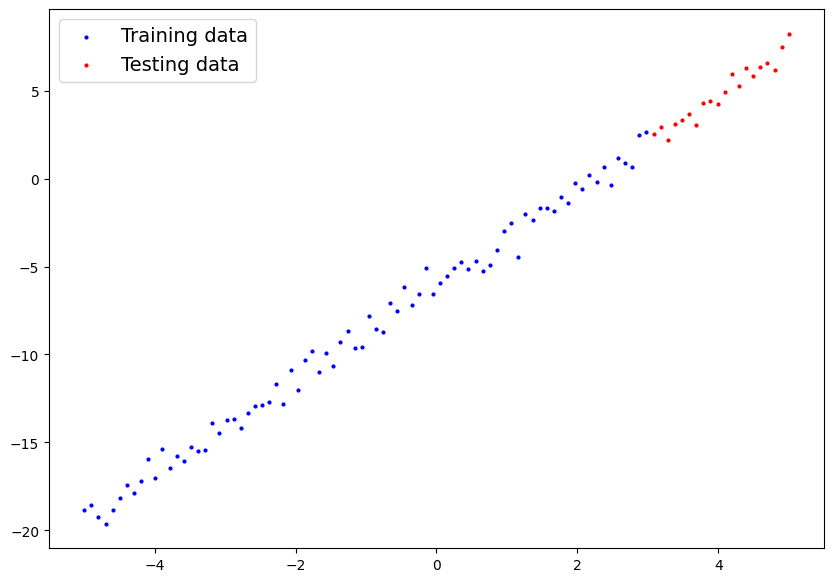

In [6]:
plot_predictions()

# Sklearn Analytical LR

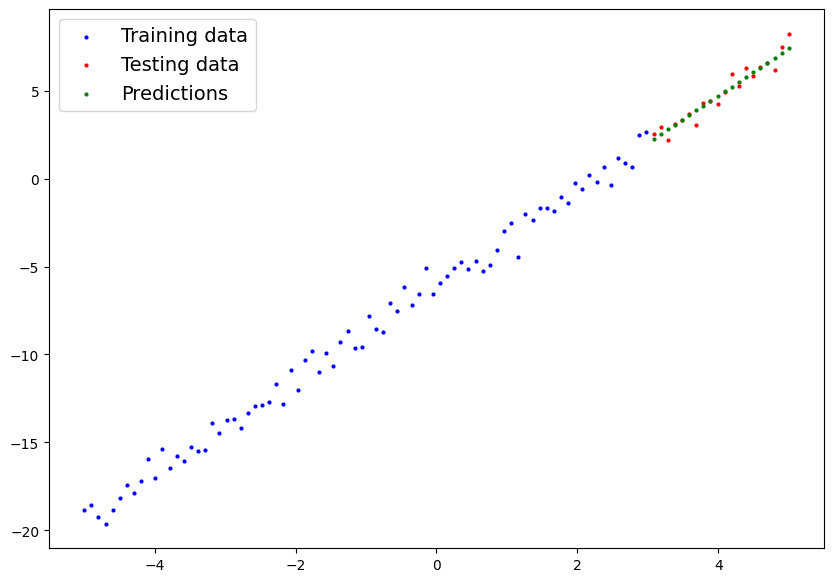

In [7]:
lr_model = LinearRegression()

lr_model.fit(X_train.detach().numpy(), y_train.detach().numpy())

w = lr_model.coef_[0][0]
b = lr_model.intercept_[0]

overall_results["Sklearn Analytical LR"] = (w, b)

plot_predictions(predictions= X_test*w+b)

# Manual Batch GD

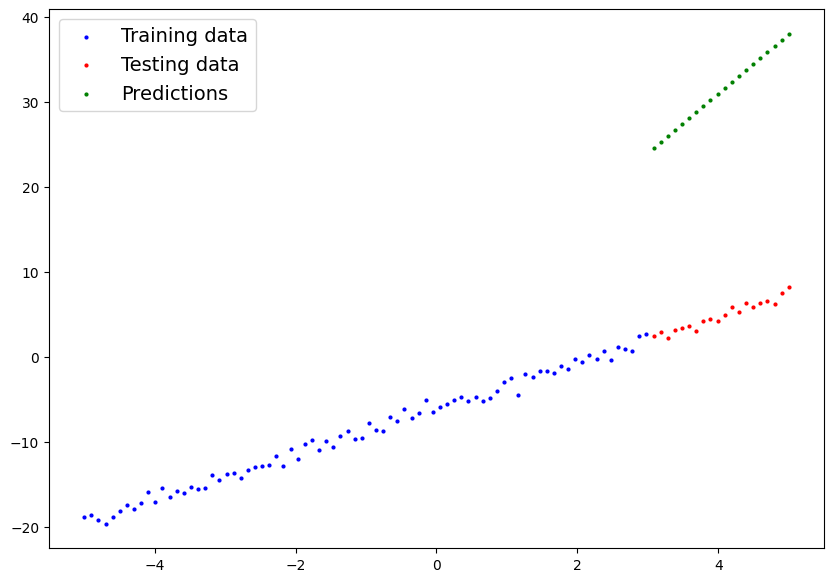

In [8]:
start_weights, start_bias = random.randrange(-10, 10), random.randrange(-10, 10)
y_preds = X_test * start_weights + start_bias
plot_predictions(predictions=y_preds)

In [9]:
def MSE_loss(y, y_pred):
  return ((y-y_pred)**2).mean()
  #mean squared error

In [10]:
def gradient_descent(X_train, y_train, y_preds):
  w = -2*(X_train*(y_train-y_preds)).mean()
  b = -2*(y_train-y_preds).mean()
  return w, b

/tmp/ipython-input-3290686875.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={"size":14})


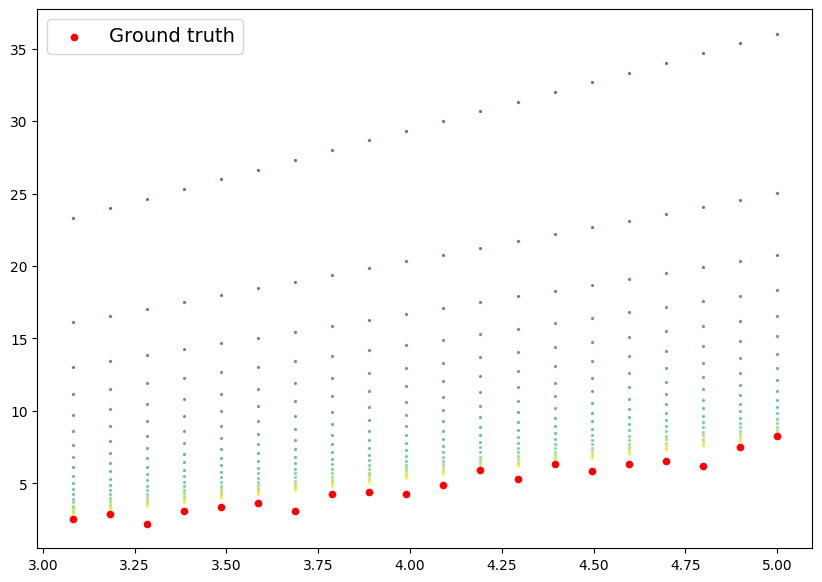

In [11]:
lr = 0.01
epochs = 200

w, b = start_weights, start_bias

loss_values = []
test_loss_values = []
epoch_count = []
calculated_b = []
calculated_w = []

plt.figure(figsize=(10, 7))

plt.legend(prop={"size":14})

colors = plt.cm.viridis(torch.linspace(0, 1, epochs//10))

for epoch in range(epochs):

  y_preds = X_train * w + b

  loss = MSE_loss(y_train, y_preds)

  dw, db = gradient_descent(X_train, y_train, y_preds)

  w, b = w - lr*dw, b - lr*db

  if(epoch%10 == 0):
    y_test_preds = X_test*w+b
    plt.scatter(X_test, y_test_preds, color=colors[epoch//10], s=2, alpha=0.5)
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(MSE_loss(y_test, y_test_preds))
    calculated_b.append(b)
    calculated_w.append(w)

plt.scatter(X_test, y_test,
            c="r", s=20, label="Ground truth")
plt.legend(prop={"size":14})

overall_results["Manual Batch GD"] = (w.detach().numpy(), b.detach().numpy())

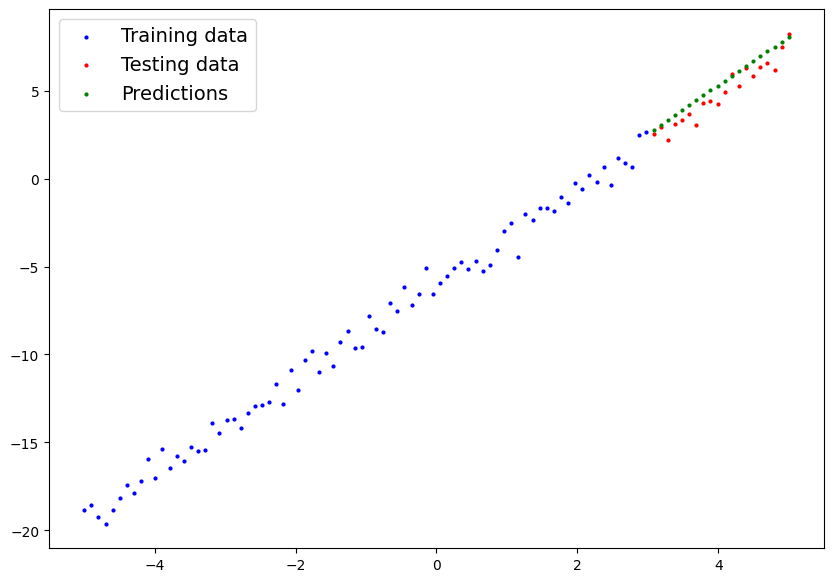

In [12]:
plot_predictions(predictions= X_test*w+b)

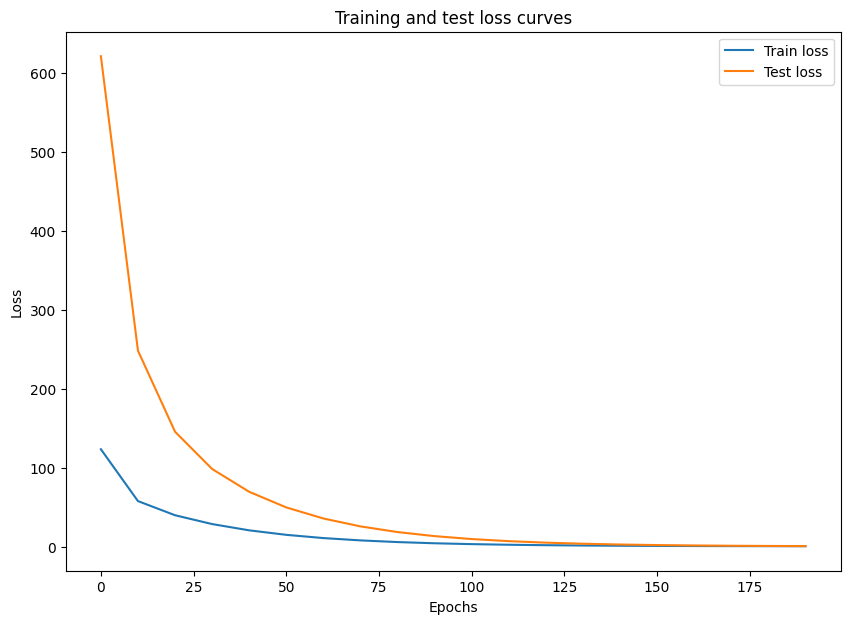

In [13]:
plot_loss_values(epoch_count, loss_values, test_loss_values)

/tmp/ipython-input-2586212381.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


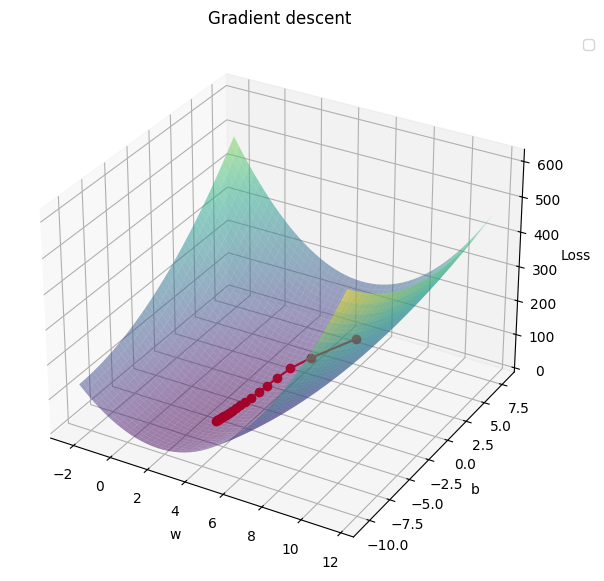

In [14]:
calculated_b = np.array(calculated_b)
calculated_w = np.array(calculated_w)

w_vals = np.linspace(calculated_w.min()-5, calculated_w.max()+5, 50)
b_vals = np.linspace(calculated_b.min()-5, calculated_b.max()+5, 50)
W, B = np.meshgrid(w_vals, b_vals)
Loss = np.zeros_like(W)

for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        y_pred = W[i,j]*X_train.detach().numpy() + B[i,j]
        Loss[i,j] = ((y_train.detach().numpy() - y_pred)**2).mean()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W, B, Loss, alpha=0.5, cmap='viridis')

ax.plot(calculated_w, calculated_b, loss_values, color='r', marker='o')
ax.set_xlabel("w")
ax.set_ylabel("b")
ax.set_zlabel("Loss")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title("Gradient descent")
plt.show()


# PyTorch Batch GD

In [15]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(
        torch.randn(1,
                    requires_grad=True,
                    dtype=torch.float)
    )
    self.bias = nn.Parameter(
        torch.randn(1,
            requires_grad = True,
            dtype = torch.float
        )
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [16]:
torch.manual_seed(52)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([-0.1455], requires_grad=True),
 Parameter containing:
 tensor([-1.1507], requires_grad=True)]

In [17]:
model_0.state_dict()

OrderedDict([('weights', tensor([-0.1455])), ('bias', tensor([-1.1507]))])

In [18]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds[:5]

tensor([[-1.5991],
        [-1.6138],
        [-1.6285],
        [-1.6432],
        [-1.6579]])

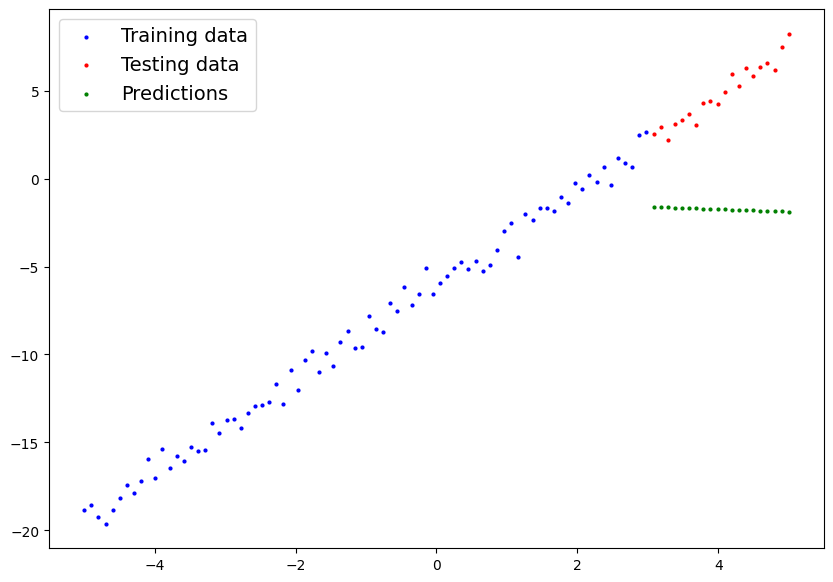

In [19]:
plot_predictions(predictions=y_preds)

In [20]:
loss_fn = nn.MSELoss()
#Работает плохо с L1Loss

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

/tmp/ipython-input-1917715122.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={"size":14})


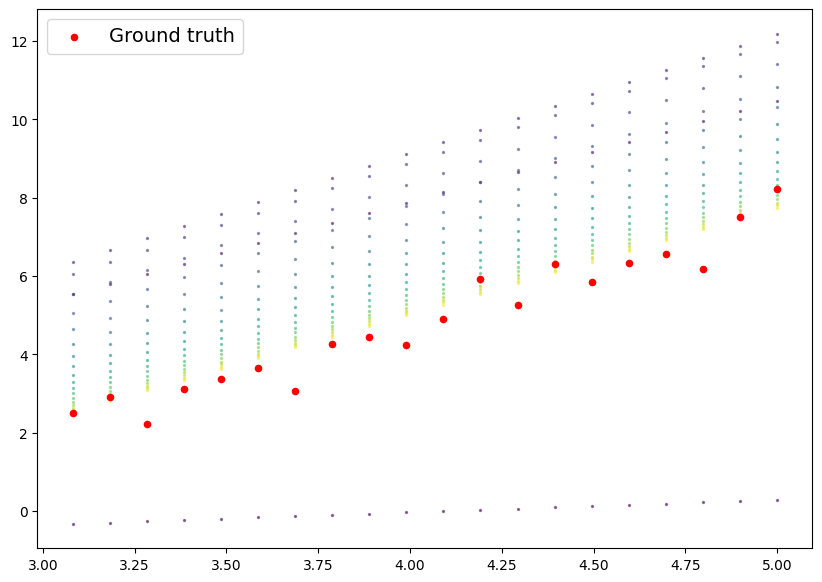

In [21]:
epochs = 200

loss_values = []
test_loss_values = []
epoch_count = []

plt.figure(figsize=(10, 7))

plt.legend(prop={"size":14})

colors = plt.cm.viridis(torch.linspace(0, 1, epochs//10))

for epoch in range(epochs):
  model_0.train()

  y_pred = model_0(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    test_preds = model_0(X_test)
    test_loss = loss_fn(test_preds, y_test.type(torch.float))

    if(epoch%10==0):
      plt.scatter(X_test, test_preds, color=colors[epoch//10], s=2, alpha=0.5)
      epoch_count.append(epoch)
      loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())

plt.scatter(X_test, y_test,
            c="r", s=20, label="Ground truth")
plt.legend(prop={"size":14})

weights, bias = model_0.parameters()

overall_results["Pytorch Batch GD"] = (weights.detach().numpy(), bias.detach().numpy())

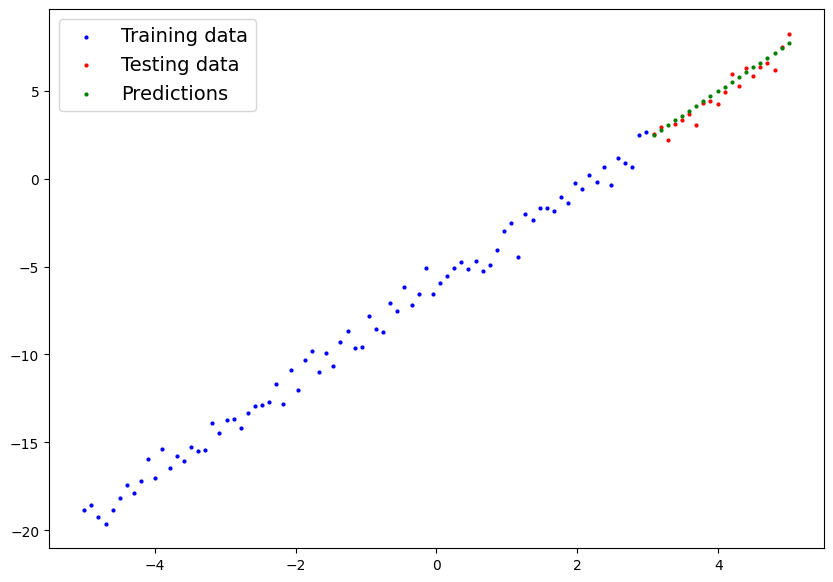

In [22]:
with torch.inference_mode():
    y_preds = model_0(X_test)
plot_predictions(predictions= y_preds)

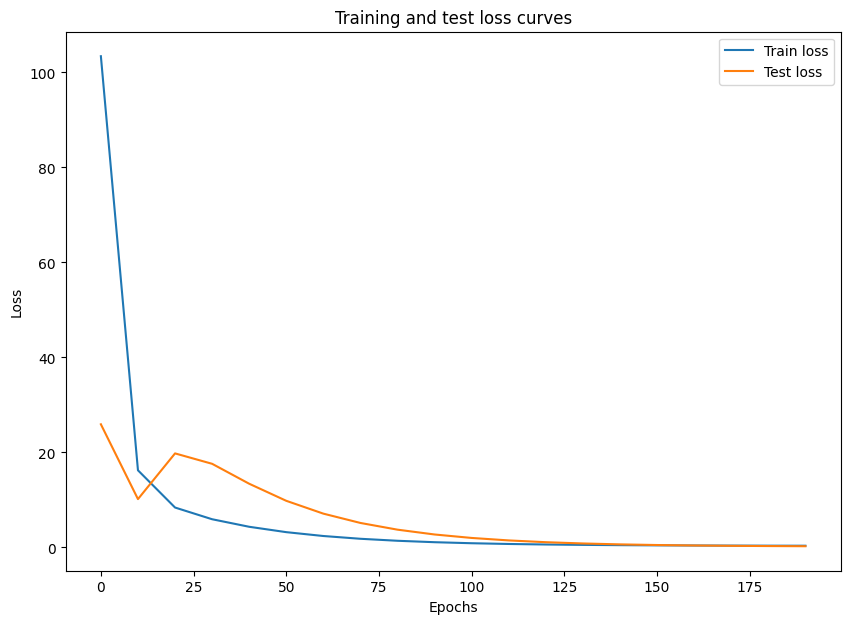

In [23]:
plot_loss_values(epoch_count, loss_values, test_loss_values)

In [24]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Pytorch_Batch_GD.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

# Methods Comparison

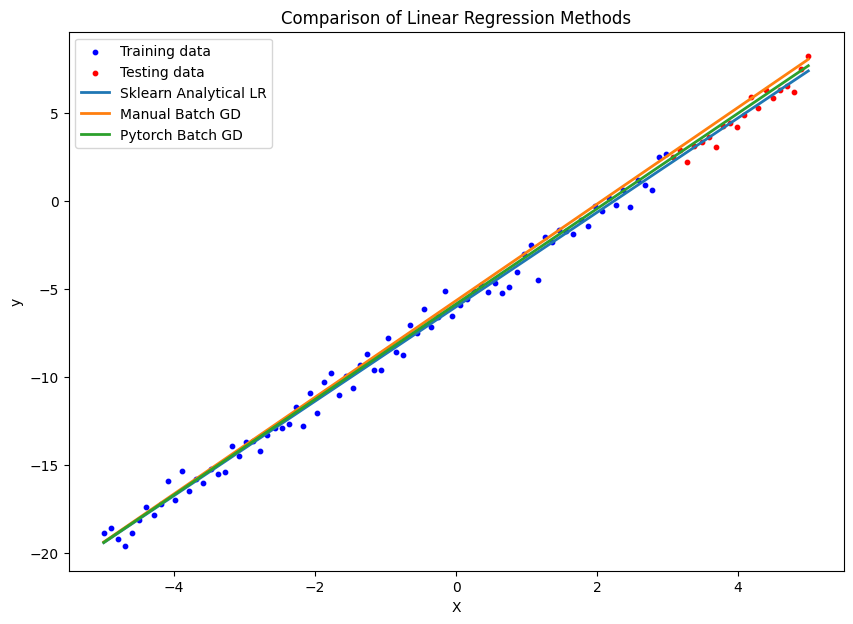

In [25]:
plt.figure(figsize=(10,7))

plt.scatter(X_train, y_train, c="blue", s=10, label="Training data")
plt.scatter(X_test, y_test, c="red", s=10, label="Testing data")

x_line = np.linspace(X.detach().numpy().min(), X.detach().numpy().max(), 100)

for method_name, (w, b) in overall_results.items():
    y_line = w * x_line + b
    plt.plot(x_line, y_line, label=method_name, linewidth=2)

plt.xlabel("X")
plt.ylabel("y")
plt.title("Comparison of Linear Regression Methods")
plt.legend()
plt.show()


# Pytorch Mini batch GD


In [37]:
#Augmenting data for correct functionality
X, y = gen_data(n_samples=10000)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X.detach().numpy(), y.detach().numpy(), test_size=0.33, random_state=52)
X_train, X_test, y_train, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_train).float(), torch.from_numpy(y_test).float()

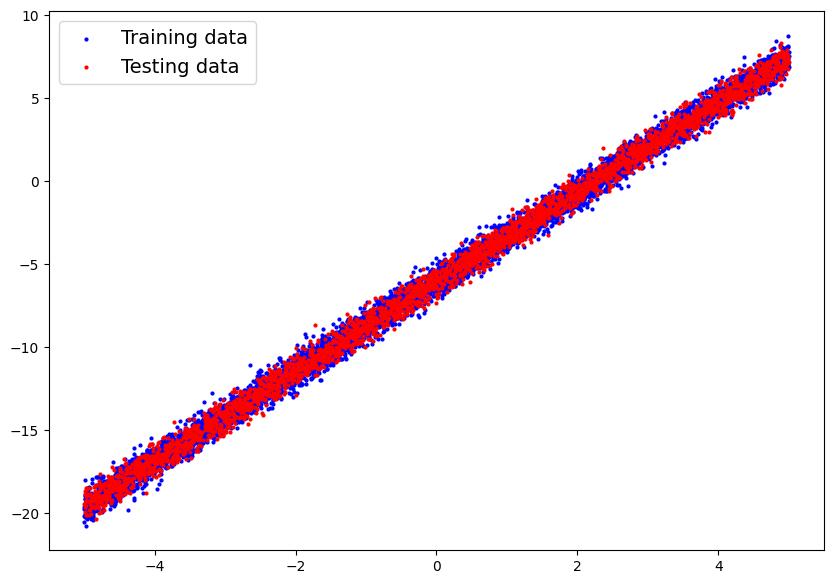

In [39]:
plot_predictions(X_train, y_train, X_test, y_test)

In [55]:
model_1 = LinearRegressionModel()

optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [49]:
def create_mini_batches(X, y, batch_size, shuffle=True):

    N = X.size(0)

    if shuffle:
        indices = torch.randperm(N)
        X = X[indices]
        y = y[indices]

    for start_idx in range(0, N, batch_size):
        end_idx = start_idx + batch_size
        X_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]
        yield X_batch, y_batch


In [56]:
epochs = 10

calculated_b = []
calculated_w = []
loss_values = []

for epoch in range(epochs):
  for X_batch, y_batch in create_mini_batches(X_train, y_train, batch_size=16, shuffle=True):

    model_1.train()

    y_pred = model_1(X_batch)

    loss = loss_fn(y_pred, y_batch)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
      weights, bias = model_0.parameters()
      calculated_b.append(bias.detach().numpy())
      calculated_w.append(weights.detach().numpy())
      loss_values.append(loss.detach().numpy())


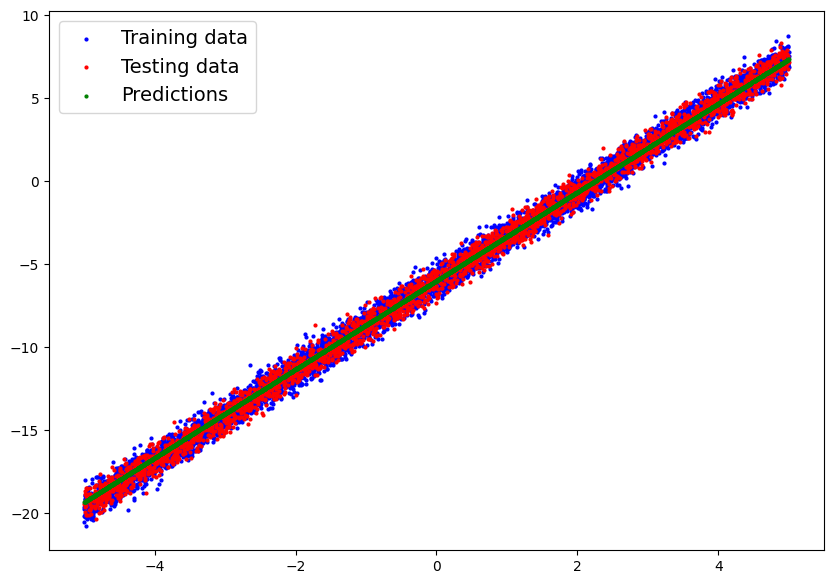

In [57]:
with torch.inference_mode():
    y_preds = model_1(X_test)
plot_predictions(X_train, y_train, X_test, y_test, predictions= y_preds)

/tmp/ipython-input-283260895.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


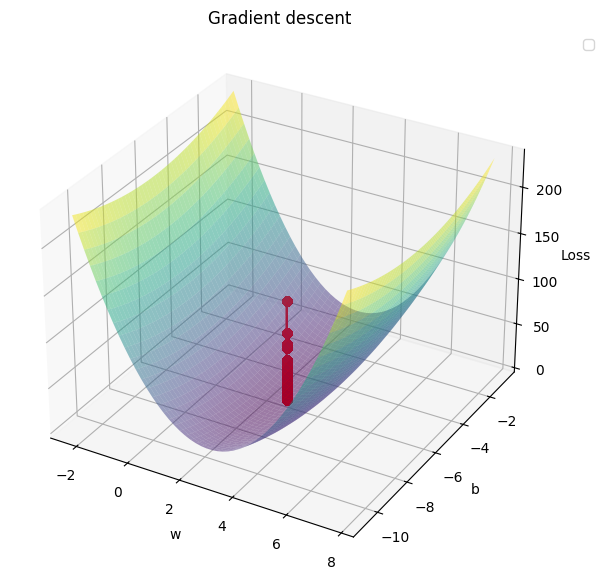

In [58]:
calculated_b = np.array(calculated_b)
calculated_w = np.array(calculated_w)

w_vals = np.linspace(calculated_w.min()-5, calculated_w.max()+5, 50)
b_vals = np.linspace(calculated_b.min()-5, calculated_b.max()+5, 50)
W, B = np.meshgrid(w_vals, b_vals)
Loss = np.zeros_like(W)

for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        y_pred = W[i,j]*X_train.detach().numpy() + B[i,j]
        Loss[i,j] = ((y_train.detach().numpy() - y_pred)**2).mean()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W, B, Loss, alpha=0.5, cmap='viridis')

ax.plot(calculated_w, calculated_b, loss_values, color='r', marker='o')
ax.set_xlabel("w")
ax.set_ylabel("b")
ax.set_zlabel("Loss")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title("Gradient descent")
plt.show()